In [1]:
from utils.draw import draw_custom_weighted_graph
from ga.tsp_ga import TSPGA
from ga.tsp_ga_din_crossover import TSPGA as TSPGAC

In [2]:
from itertools import permutations
import random
from tqdm import tqdm
def generate_network(num_nodes, rand_a, rand_b):
    nodes_list = [x for x in range(num_nodes)]
    edges = list(permutations(nodes_list, 2))
    edges_w = [(*x, random.randint(rand_a,rand_b)) for x in edges]

    return nodes_list, edges_w

def evaluate_several_options(gas = [], steps_number = 100):
    steps = []
    costs_list = [[] for _ in gas]
    for step in tqdm(range(steps_number), desc="Running RA for all options"):
        for idx, ga in enumerate(gas):
            new_population, new_costs = ga.step()
            tour,cost = min(zip(new_population, new_costs), key=lambda el:el[1])
            costs_list[idx].append(cost)
        steps.append(step)
    return steps, costs_list

In [3]:
def generate_one_side_grid(params, attribute, values ):
    params_list = []
    labels = []
    for value in values:
        param = params.copy()
        param[attribute] = value
        params_list.append(param)
        labels.append(f"{attribute}:{value}")
    return params_list, labels

In [4]:
import numpy as np
from functools import reduce

def calculate_percentile(value, values):
    # Convert the input values to a numpy array
    values = np.array(values)
    
    # Calculate the percentile rank of the given value
    percentile_rank = (np.sum(values < value) / len(values) * 100)//1
    
    return percentile_rank
    
def calculate_percentiles(costs, comparing_step = 100):
    # Get the final cost for each scenario (the last element in each list)
    flat_costs = reduce(lambda a,b : a+b, costs)
    
    
    # Calculate the percentile rank of the given value
    percentile_rank = [calculate_percentile(cost[comparing_step], flat_costs) for cost in costs]
    
    return percentile_rank


In [5]:
import multiprocessing as mp


def evaluate_several_options_single(ga, steps_number=100):
    steps = []
    costs_list = []
    for step in tqdm(range(steps_number), desc=f"Running GA for single option", leave=False):
        new_population, new_costs = ga.step()
        tour, cost = min(zip(new_population, new_costs), key=lambda el: el[1])
        costs_list.append(cost)
        steps.append(step)
    return steps, costs_list

def evaluate_several_options_parallel(gas, steps_number=100):
    # Create a pool of workers
    with mp.Pool(mp.cpu_count()) as pool:
        # Parallelize the evaluation of all GA instances
        results = pool.starmap(evaluate_several_options_single, [(ga, steps_number) for ga in gas])

    # Unpack the results
    steps = [result[0] for result in results]  # List of step sequences for each GA
    costs_list = [result[1] for result in results]  # List of cost sequences for each GA
    return steps, costs_list

# Finding best crossover based on population

In [6]:
%%time

results = {}
cost_dict = {}

values_to_iterate = [round(x/10,1) for x in range(1,11,1)]
for NUM_NODES in [20,40,60,80]:
    print(NUM_NODES)

    nodes_list, edges_w = generate_network(num_nodes=NUM_NODES,rand_a=0,rand_b=200)
    
    params = {
    "population_prop":1.1, "crossover_proportion":0.7,"mutation_thd":0.2, "exploration_prob":0.2
    }
    params_list, labels = generate_one_side_grid(params, "crossover_proportion", values = values_to_iterate)
    
    gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]
    
    steps, costs = evaluate_several_options_parallel(gas=gas, steps_number=100)
    results[f"testing {NUM_NODES} nodes"] = calculate_percentiles(costs, comparing_step=50)
    cost_dict[f"testing {NUM_NODES} nodes"] = costs

20


40


60


80


CPU times: user 507 ms, sys: 391 ms, total: 898 ms
Wall time: 32.6 s


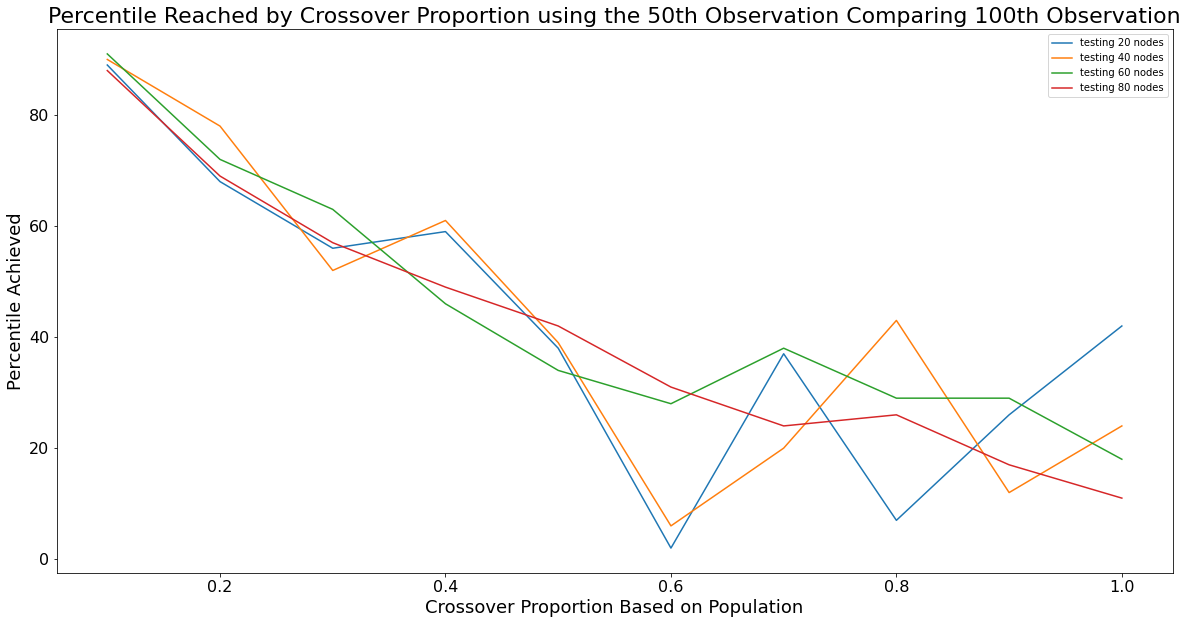

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))

# Plotting data
for idx, values in results.items():
    sns.lineplot(x=values_to_iterate, y=values, label=idx)

# Adding titles and labels with larger font sizes
plt.title("Percentile Reached by Crossover Proportion using the 50th Observation Comparing 100th Observation", fontsize=22)
plt.xlabel("Crossover Proportion Based on Population", fontsize=18)
plt.ylabel("Percentile Achieved", fontsize=18)

# Increasing the font size of the ticks on both axes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the plot as a PNG file
plt.savefig('imgs/crossover_proportion_vs_percentile.png', format='png', dpi=300)

# Display the plot
plt.show()

In [8]:
import pandas as pd
df = pd.DataFrame(data=results.values(), columns=labels)
df.index = results.keys()
avg_list = [df[fld].mean() for fld in df.columns]
df = df.T
df["AVG"] = avg_list
df

,testing 20 nodes,testing 40 nodes,testing 60 nodes,testing 80 nodes,AVG
crossover_proportion:0.1,89.0,90.0,91.0,88.0,89.50
crossover_proportion:0.2,68.0,78.0,72.0,69.0,71.75
crossover_proportion:0.3,56.0,52.0,63.0,57.0,57.00
crossover_proportion:0.4,59.0,61.0,46.0,49.0,53.75
crossover_proportion:0.5,38.0,39.0,34.0,42.0,38.25
crossover_proportion:0.6,2.0,6.0,28.0,31.0,16.75
crossover_proportion:0.7,37.0,20.0,38.0,24.0,29.75
crossover_proportion:0.8,7.0,43.0,29.0,26.0,26.25
crossover_proportion:0.9,26.0,12.0,29.0,17.0,21.00
crossover_proportion:1.0,42.0,24.0,18.0,11.0,23.75


In [9]:
df.to_csv("data/crossover_proportion.csv")

In [10]:
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  testing 20 nodes &  testing 40 nodes &  testing 60 nodes &  testing 80 nodes &    AVG \\
\midrule
crossover\_proportion:0.1 &              89.0 &              90.0 &              91.0 &              88.0 &  89.50 \\
crossover\_proportion:0.2 &              68.0 &              78.0 &              72.0 &              69.0 &  71.75 \\
crossover\_proportion:0.3 &              56.0 &              52.0 &              63.0 &              57.0 &  57.00 \\
crossover\_proportion:0.4 &              59.0 &              61.0 &              46.0 &              49.0 &  53.75 \\
crossover\_proportion:0.5 &              38.0 &              39.0 &              34.0 &              42.0 &  38.25 \\
crossover\_proportion:0.6 &               2.0 &               6.0 &              28.0 &              31.0 &  16.75 \\
crossover\_proportion:0.7 &              37.0 &              20.0 &              38.0 &              24.0 &  29.75 \\
crossover\_proportion:0.8 &          

/tmp/ipykernel_61961/2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


# Justify

In [11]:
result_dict = df[["AVG"]].to_dict("idx")
av, bv, cv = "crossover_proportion:0.1", "crossover_proportion:0.5", "crossover_proportion:0.9"
a = result_dict[av]["AVG"]
b = result_dict[bv]["AVG"]
c = result_dict[cv]["AVG"]
a

/tmp/ipykernel_61961/2248079007.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  result_dict = df[["AVG"]].to_dict("idx")


89.5

In [12]:
print(f"Using {av} vs {bv} an improvement of: {a} - {b} = ", a - b)
print(f"Compared with {bv} vs {cv} an improvement of: {b} - {c} = ", b - c)

Using crossover_proportion:0.1 vs crossover_proportion:0.5 an improvement of: 89.5 - 38.25 =  51.25
Compared with crossover_proportion:0.5 vs crossover_proportion:0.9 an improvement of: 38.25 - 21.0 =  17.25


In [13]:
print("Using 0.1 vs 0.5 an improvement of: 84.50 - 23.50 = ", 84.50 - 23.50)
print("Compared with 0.5 vs 0.9 an improvement of: 23.50 - 15.75 = ", 23.50 - 15.75)

Using 0.1 vs 0.5 an improvement of: 84.50 - 23.50 =  61.0
Compared with 0.5 vs 0.9 an improvement of: 23.50 - 15.75 =  7.75


### Conclution
0.8 param will be used